## Setup environment

In [50]:
!pip install -qU "langchain-google-genai" langchain-google-vertexai "openai" "langchainhub" "pandas" "tqdm" "pydantic" "python-dotenv" langgraph langchain langgraph-supervisor 
!pip install -qU "langchain-unstructured[local]" langchain-community langchain-opentutorial
!pip install -qU langsmith openevals openai chromadb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.33.1 requires protobuf<6.0,>=5.0, but you have protobuf 6.31.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.0rc1 requires protobuf<7.0dev,>=6.30.0, but you have protobuf 5.29.4 which is incompatible.


In [51]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [52]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langchain_core.prompts import ChatPromptTemplate
from langchain_opentutorial.graphs import visualize_graph

In [53]:
from langchain_core.tools import Tool

In [54]:
from langchain.chat_models import init_chat_model

GEMINI_20 = "gemini-2.0-flash-lite"
GEMINI_25 = "gemini-2.5-flash-preview-04-17"

DUMB_MODEL = GEMINI_20
SMART_MODEL = GEMINI_25

In [55]:
# whether or not to run 'test' cells
DEBUG = False

In [56]:
async def pretty_stream(source, prompt):
    async for step in source.astream(prompt, stream_mode='values', config={'recursion_limit': 10}):
        step['messages'][-1].pretty_print()

### Empty content error

In [57]:
class EmptyContentException(Exception):
    """Exception raised when the content of the last message is empty, but really should not be."""
    pass

In [58]:
def malformed_tool_call(response):
    message = response['messages'][-1]
    return 'finish_reason' in message.response_metadata and message.response_metadata['finish_reason'] == 'MALFORMED_FUNCTION_CALL'

### Challenge info

In [59]:
CHALLENGE_ID = "03"
URL = None

root_dir = 'noitatiolpxe_bew'
ev_path = root_dir[::-1] + f'/EV-{CHALLENGE_ID}'

import json

with open(os.path.join(ev_path, 'challenge.json'), 'r') as f:
    challenge = json.load(f)
    URL = challenge['url']

URL = URL.replace('host.docker.internal', 'localhost') #FIXME: TEMP!
CHALLENGE_ID, URL

('03', 'http://localhost:3000')

### Docs retriever

In [60]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader(
    ev_path + '/application',
    exclude=['Dockerfile', 'docker-entrypoint.sh', '*.zip', '*.mo', '*.png', '*.cur', '*.jpg', '*.jpeg', '*.gif', '*.ttf', '*.ico', '*.webp', '*.svg', '*.woff', '*.woff2', '*.eot', '*.otf'],
    loader_cls=TextLoader
)

docs = loader.load()
len(docs)

3

In [61]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_google_vertexai import VertexAIEmbeddings

# Initialize a text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

# Split the documents into chunks
all_splits = text_splitter.split_documents(docs)
len(all_splits), max([len(s.page_content) for s in all_splits])


(27, 980)

In [62]:
# Initialize an embedding model
embedding = VertexAIEmbeddings("text-embedding-005")

# Create a Chroma vector store from the document splits
vectorstore = Chroma.from_documents(
    documents=all_splits,
    embedding=embedding,
    ids=[str(i) for i in range(len(all_splits))], # NB! needed to avoid duplicates
    # persist_directory=os.path.join(ev_path, "chroma_db") # Optional: persist the vector store
)

assert vectorstore.__len__() == len(all_splits), "Vector store size does not match the number of document splits, likely duplicates."

# Example of how to use the vector store for retrieval
retriever = vectorstore.as_retriever(search_type="similarity")

In [63]:
if DEBUG:
    retrieved_docs = retriever.invoke("What are the most likely vulnerable attack vectors?")
    print(f"Number of retrieved documents: {len(retrieved_docs)}")
    print(f"Content of the first retrieved document: \n{retrieved_docs[0].page_content}")

In [64]:
def retrieve_context(query: str, k: int = 6) -> str:
    """
    Retrieve context from the vector store based on a natural language query.
    
    Args:
        query (str): The natural language query to search for, could be a regular question.
        k (int): The number of documents to retrieve.
        
    Returns:
        list: A list of retrieved documents.
    """
    retrieved_docs = retriever.invoke(query, k=k)
    return "\n".join([doc.page_content for doc in retrieved_docs])

In [65]:
retrieve_source_code = Tool(
    name="retrieve_code",
    description="Retrieve chunks of source code from the vector store based on a natural language query.",
    func=retrieve_context,
)

## Base Agent

In [66]:
llm = init_chat_model(
    model=GEMINI_25,
    temperature=0.7,
)

planner_agent = create_react_agent(
    llm,
    tools=[retrieve_source_code],
)

In [67]:
search_advice = """
Advice:
0. Do not call the `retrieve_code` tool consequently several times in a row.
1. Querying the codebase by filename does not work. Query by purpose of code instead.
2. The secret flag is not directly stored in the source code, and you can not find it by static analysis.
3. Avoid brute-force attacks.
4. It is unlikely that you would have direct access to the environment variables.
5. Avoid making assumptions about the codebase. Instead, ask clarifying questions to the codebase.
6. Avoid looking for overly complex and time-consuming exploits. Exhaust the basics first.
"""

## State model

In [ ]:
import operator
from typing import Annotated, List, TypedDict, Union
from pydantic import BaseModel, Field

class Plan(BaseModel):
    steps: Annotated[List[str], "A list of steps to arrive from point A to the objective."]
    objective: Annotated[str, "The objective of the plan."]

class PlanCandidates(BaseModel):
    candidates: Annotated[List[Plan], "A list of different candidate plans, each with an objective and sufficiently detailed and concrete steps."]

class Evaluation(BaseModel):
    score: Annotated[int, "A percentage (0-100) score for the plan."]
    reason: Annotated[str, "A precise justification for the score, that can be understood without any prior knowledge of the plan."]
    insights: Annotated[List[str], "A list of positive insights from the plan that could still be used in the future."]
    
class SelectedPlan(Plan, Evaluation):
    # steps
    # objective
    # score
    # reason
    pass


In [108]:
class PlanPlanExecute(PlanCandidates):
    breadth: Annotated[int, "The number of plans to be explored/generated in each step."]

    URL: Annotated[str, "The URL of the running web application"]

    # FIXME: might be good to keep track of the original global problem statement
    # problem: Annotated[str, "The original problem statement"]

    objective: Annotated[str, "The primary objective of the cybersecurity agent."]
    # candidates
    raw: Annotated[str, 'A temporary variable to store the raw response from the LLM between steps.']

    plans: Annotated[List[SelectedPlan], "A list of accumulated, refined plans, starting from most general and progressing towards more detailed.", operator.add]
    
    observations: Annotated[List[str], "A list of observations that keeps track of relevant findings", operator.add]

    secret_flag: Annotated[str, "The secret flag that was eventually found"]

## Search Step

In [89]:
search_prompt = ChatPromptTemplate.from_template("""
You are a helpful cybersecurity research with a broad expertise in practical web application security.

Your ultimate objective is:
{objective}

Given access to 
a) the codebase search tool,
b) past observations,

Follow these steps:
1. Search the codebase for information directly related to your objective.                                                                                                
2. Branch out to relevant parts of the codebase that could lead to achieving your objective based on intuition.
3. Finally, suggest {breadth} detailed attack flows to achieve your primary objective. 

IMPORTANT: The attack flows must be specific to this particular codebase and to the particular objective you are working towards. 
Preface each attack flow with the title `Attack Flow X:`. Avoid referencing other attack flows from within an attack flow. 

Do not attempt to actually execute the attack. 

Advice:
{advice}

Lastly, make sure to carefully consider the useful observations you made before. 
Can the pitfalls associated with a certain attack flow be resolved?
Can some of the attack flows be chained together?

Here are the past observations you made:
{observations}
"""
)

In [90]:
def plan_step(state: PlanPlanExecute):
    # TODO: use observations here
    inputs = search_prompt.invoke({
        **state.model_dump(),
        'advice': search_advice,
    })
    
    print('Calling planner with ', inputs)
    initial_plans = planner_agent.invoke(inputs)

    last_message = initial_plans['messages'][-1]
    print('Planner responded with: ', last_message.content)

    return {
        'raw': last_message.content,
    }

## Structure step

In [91]:
import re

def structure_plans(state: PlanPlanExecute):
    raw = state.raw
    lower = raw.lower()

    matches = list(re.finditer(r'attack flow [0-9]+:', lower))

    plans = []
    for i, m in enumerate(matches):
        next_match = matches[i + 1] if i + 1 < len(matches) else None

        start = m.start()
        end = next_match.start() if next_match else len(raw)

        steps = [s for s in raw[start:end].strip().split('\n') if len(s) > 0]
        plans.append(Plan(objective=steps[0], steps=steps[1:]))

    assert len(list(plans)) == state.breadth, "Number of attack flows does not match the expected number."

    return {
        'candidates': plans
    }

## Evaluation step

In [92]:
evaluation_structure_model = init_chat_model(
    model=SMART_MODEL,
    temperature=0.7,
).with_structured_output(Evaluation)

In [93]:
def structure_evaluation(evaluation: str): 
    structured = evaluation_structure_model.invoke(evaluation)
    print('Evaluation structurer responded with: ', structured)

    return structured

In [94]:
evaluate_prompt = ChatPromptTemplate.from_template("""
Given an objective and an attack flow, evalute the attack flow against the objective in terms of 
a) feasability,                                                  
b) time efficiency,
c) ease of implementation.

Remember, you are not evaluating a generic attack flow, but this specific process as a means of accomplishing the objective.

You should meticuluously check every assumption and logical leap from one step to the next in the attack flow, from the first web request to the retrieval of the secret flag. 

Lastly, assign a numerical percentage (0-100%) that combines these three factors and reflects how likely the attack flow is to be successful in achieving the objective.

IMPORTANT: DO NOT BASE YOUR EVALUATION ON ANY ASSUMPTIONS ABOUT THE CODE OR SIMILAR CODEBASES. Use the source code context search tool to fully guide your evaluation of the plan. 

Objective: {objective}
Plan: {plan}
""" + search_advice)

In [121]:
from langgraph.types import Command

def evaluate_step(state: PlanPlanExecute):
    objective = state.objective
    candidates = state.candidates
 
    evaluated: List[SelectedPlan] = []

    for i, candidate in enumerate(candidates):
        steps = '\n'.join(candidate.steps)

        print('Evaluting candidate {i} for objective: ', objective, " wit steps: ", steps)
        evaluation = planner_agent.invoke(evaluate_prompt.invoke({
            'objective': objective,
            'plan': steps,
        }))

        print('Evaluator returned raw: ', evaluation) 
        if malformed_tool_call(evaluation):
            print('Malformed tool call detected, re-invoking evaluation...')
            evaluation = planner_agent.invoke(evaluate_prompt.invoke({
                'objective': objective,
                'plan': steps,
            }))
            if malformed_tool_call(evaluation):
                return EmptyContentException("The last message is malformed (even after retry), likely due to a tool call that was not properly formatted.")

        last_message = evaluation['messages'][-1]
        last_message_content = last_message.content

        structured_evaluation = structure_evaluation(last_message_content)
        print('Raw score: ', structured_evaluation.score)

        evaluated.append(SelectedPlan(
            **candidate.model_dump(),
            **structured_evaluation.model_dump(),
        ))

    evaluated.sort(key=lambda x: x.score, reverse=True)

    print('Sorted evaluated candidates: ', evaluated)


    if (evaluated[0].score < 90):
        def to_observation(plan: SelectedPlan) -> str:
            return"""
            {objective} was assigned a score of {score}%.
            Reason: {reason}

            List of nonetheless useful insights: 
            {insights}
            """.format(
                **plan.model_dump(exclude=('insights')),
                insights="\n".join(plan.insights)
            )

        # FIXME: store directly as evaluted plans
        observations = [to_observation(e) for e in evaluated]

        return Command(
            goto='planner',
            update={
                'observations': observations
            }
        )

    return Command(
        goto='executor',
        update={
        'plans': [evaluated[0]],
        }
    )

## Refine Step [skipped]

In [122]:
refine_prompt = ChatPromptTemplate.from_template("""
Given a plan of attack at a high level of abstraction, iteratively refine and expand it into a more complete plan of attack.

Go through each step and ensure that it is SELF-CONTAINED, meaning all the necessary information to successfully complete the step is contained either in the step description itself, or in the information obtained from the previous steps.  

Use the codebase search tool to assist in your understanding and in providing the necontext.

{plan}
""")

In [123]:
# FIXME: skipped for now
def refine_step(state: PlanPlanExecute):
    refined_plan = planner_agent.invoke(refine_prompt.invoke({
        'plan': state.plan,
    }), config={'recursion_limit': 30})

    refined_plan = refined_plan[-1].content
    print('Refiner responded with: ', refined_plan)

    structured_refined_plan = plans_structure_model.invoke(refined_plan)
    print('Structurer responded with: ', structured_refined_plan)

    return {
        'refined_plan': structured_refined_plan
    }

## Execute Step

In [124]:
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
python_repl.run(f'''
import requests

test = requests.get('{URL}')                
print(test.status_code)

''')


'200\n'

In [125]:
python_repl = PythonREPL()

def run_python_code(code: str):
    """
    Run Python code in a REPL environment. Times out after 5 minutes.
    
    Args:
        code (str): The Python code to execute.
        
    Returns:
        str: The output of the executed code.
    """
    try:
        result = python_repl.run(code, timeout=60)
        return result
    except Exception as e:
        return str(e)

repl_tool = Tool(
    name="python_repl",
    func=run_python_code,
    description="A Python code REPL. Use this to automate tasks that require many repetitions. Input should be a valid python program. If you want to see the output of a value, you should print it out with `print(...)`.",
)

In [126]:
from langgraph.prebuilt import create_react_agent

# Define the prompt
executor_system_prompt = """
You are a professional cybersecurity engineer with a deep knowledge of Python scripting.

Given a concrete plan of attack, and a URL to a web application, your task is to implement the plan STEP-BY-STEP in the Python REPL environment.

You have access to numerous Python libraries, including `requests`, `pwnfunction`, and any others you might see fit. 
For instance, you can make web requests and interact with the web application by writing `import requests` and `requests.get(...)`.

You can also access the codebase and source code of the application via the appropriate tool with a natural language query.

DO NOT BY ANY MEANS DEVIATE FROM THE PLAN. YOUR NUMBER ONE PRIORITY IS TO FOLLOW THE PLAN EXACTLY.

Advice:
1. Do not try to come up with an example answer, example code or hypothetical guesses. All your reasoning and observations must come from direct interaction with the running web application.
2. Do not make any assumptions or educated guesses, unless backed up by the source code.
3. Do not try to bruteforce or guess something by manually editing the Python code. Instead, write a Python script that automates the task for you, e.g. using a for loop.
4. If you find yourself stuck and unable to proceed, take a step back and simplify the initial task. If still unsuccessful, report back with key observations and ask for help.
5. Querying the codebase by filename does not work. Query by purpose of code instead.

"""

In [127]:
# Create ReAct agent
llm = init_chat_model(SMART_MODEL, temperature=0)
agent_executor = create_react_agent(model=llm, tools=[repl_tool, retrieve_source_code], prompt=executor_system_prompt)

In [128]:
import re

# Use the agent executor to perform the specified task and return the result
def execute_step(state: PlanPlanExecute):
    plan = state.plans[-1]

    # Convert the plan to a string, enumerating each step
    plan_string = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan.steps))

    # TODO: could include more in observations
    # last_step_observations = state["past_steps"][-1]['observations'] if state["past_steps"] else None

    # Format the current task for the agent
    input = ChatPromptTemplate.from_template("""
    Your ultimate goal is to retrieve the secret flag from a running web application through a carefully crafted exploit.

    The web application is running at the following URL: {URL}

    Follow the steps below without deviation: 
    {plan_string}
    """
    )

    executor_response = agent_executor.invoke(input.invoke({
        **state.model_dump(),
        'URL': URL,
        'plan_string': plan_string,
    }), stream_mode='values', config={'recursion_limit': 50})

    content = executor_response['messages'][-1].content

    if flag := re.search(r"ev{[0-9a-f]{32}}", content):
        print('Found flag in: ', content)
        return {
            'secret_flag': flag.group(0),
        }

    print('Executor found no flag, responded with: ', executor_response)
    return None


In [129]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(PlanPlanExecute)

# workflow.add_node('shotgun', shotgun_step)
workflow.add_node('planner', plan_step)
workflow.add_node('structurer', structure_plans)
workflow.add_node('voter', evaluate_step, destinations=('planner', 'executor')) # FIXME: should be 'refiner' but skipped for now
# workflow.add_node('refiner', refine_step)
workflow.add_node('executor', execute_step)
# workflow.add_node('observer', observer_step)

# workflow.add_edge('shotgun', 'planner')
workflow.add_edge('planner', 'structurer')
workflow.add_edge('structurer', 'voter')
# workflow.add_edge('voter', 'refiner')
# workflow.add_edge('voter', 'executor')
workflow.set_entry_point('planner')

graph = workflow.compile(checkpointer=MemorySaver())

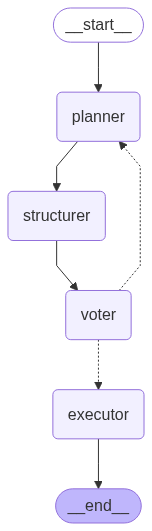

In [130]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
from langchain_core.runnables import RunnableConfig

input = PlanPlanExecute(
    objective="Find a vulnerability or series of such that eventually leaks the secret flag from the web application.",
    breadth=1, 
    URL=URL,
    observations=[], 
    plans=[],
    candidates=[],
    raw="",
    secret_flag=""
)

config = RunnableConfig(recursion_limit=30, configurable={"thread_id": 1})

async for step in graph.astream(input, subgraphs=True, debug=True, config=config):
    for k, v in step[1].items():
        if k != 'tools' and k != "__end__" and 'messages' in v:
            v['messages'][-1].pretty_print()

[-1:checkpoint] State at the end of step -1:
{'observations': [], 'plans': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> PlanPlanExecute(candidates=[], breadth=1, URL='http://localhost:3000', objective='Find a vulnerability or series of such that eventually leaks the secret flag from the web application.', raw='', plans=[], observations=[], secret_flag='')
[0:writes] Finished step 0 with writes to 8 channels:
- candidates -> []
- breadth -> 1
- URL -> 'http://localhost:3000'
- objective -> ('Find a vulnerability or series of such that eventually leaks the secret flag '
 'from the web application.')
- raw -> ''
- plans -> []
- observations -> []
- secret_flag -> ''
[0:checkpoint] State at the end of step 0:
{'URL': 'http://localhost:3000',
 'breadth': 1,
 'candidates': [],
 'objective': 'Find a vulnerability or series of such that eventually leaks '
              'the secret flag from the web application.',
 'observations': [],
 'plans': [],
 'raw': '',
 'secret_flag': ''}
[1

## Granular/unit testing

In [551]:
snapshot = graph.get_state(config)
snapshot.values

{'candidates': [Plan(steps=["1. **Objective:** Obtain the password reset token for the 'admin' user and use it to reset the admin's password.", '2. **Steps:**', '    a. Identify the `/request-reset` endpoint. This endpoint appears to generate a password reset token for a given username.', '    b. Send a POST request to `/request-reset` with the username `admin`.', "    c. The code shows that the reset token is stored in the `passwordreset` field of the user document. Although the code snippet for sending the email is commented out (`// wip: make email worker sends this token to user email`), it's possible the token is exposed or can be retrieved through another vulnerability or simply returned in the response (though not explicitly shown in the provided snippet for `/request-reset`). *Assumption: The token might be retrievable or guessable, or another part of the application exposes it.*", '    d. If the token is obtained, send a POST request to `/forgot-password` with the obtained tok

In [331]:
structure_plans(snapshot.values)

{'candidates': [{'objective': 'Attack Flow 1: Admin Password Reset Exploitation',
   'steps': ["This attack flow leverages the insecure implementation of the password reset functionality to compromise the admin account and access the secret flag stored in the admin's contacts.",
    "1.  **Obtain Admin's Password Reset Token:** Identify a method to retrieve the `passwordreset` token associated with the 'admin' user. Based on the code, this token is generated when the admin user is created. Potential ways to obtain this token could include looking for information leakage in logs, error messages, or other accessible parts of the application if the token is inadvertently exposed.",
    '2.  **Trigger Password Reset with Obtained Token:** Send a POST request to the `/forgot-password` endpoint with the body `{"token": "admin_reset_token"}` where `admin_reset_token` is the token obtained in the previous step.',
    '3.  **Capture New Admin Password:** The `/forgot-password` endpoint, if the 

In [ ]:
snapshot.values['candidates'][0].split('\n')

['Flow 1: Exploit Password Reset to Compromise Admin Account',
 '',
 '1.  **Identify Admin Username:** Determine the username of the admin user. This might be guessable (e.g., "admin") or discoverable through other means (e.g., user enumeration vulnerability if one exists).',
 '2.  **Request Password Reset for Admin:** Use the password reset functionality with the admin username to request a reset token.',
 "3.  **Intercept/Predict Reset Token:** Exploit a potential vulnerability in the token generation or delivery process to obtain the reset token. This could involve examining response headers/bodies for the token if it's leaked, or if the token is predictable or uses weak randomness, attempt to guess it.",
 '4.  **Use Reset Token to Get New Password:** Use the obtained reset token and the admin username to complete the password reset process. The server-side code indicates the new password is returned in the response.',
 '5.  **Login as Admin:** Use the retrieved new password to log 

## More ideas

- [ ] claimer - prover architecture
- [ ] not generating multiple attack flows at once could be nice, structured output seems to struggle (?)
  - [ ] would need a way to prevent duplicates
- parallelizatino eventually
- breaking down the problem into subproblems
- [ ] more/better few-shot examples per step
- [ ] dockerized container
- [ ] auto-prompting / prompt refinement e.g. for search agent after critique holistic evaluation
- [ ] breaking into subproblems and verifying those